In [1]:
import pandas as pd
import datetime
import numpy as np

from catboost import CatBoostRegressor

import matplotlib.pyplot as plt
import seaborn as sns

# Импорт денежных аггрегатов и денежной массы

- источник: [сайт ЦБ](https://cbr.ru/statistics/macro_itm/dkfs/monetary_agg/)

In [2]:
monetary_agg = pd.read_excel('../data/monetary_agg.xlsx').transpose()
monetary_agg.columns = monetary_agg.iloc[0]
monetary_agg = monetary_agg.iloc[1:]
monetary_agg = monetary_agg.loc[:, ['Денежный агрегат М0', 'Денежный агрегат М1']].dropna()
monetary_agg['date'] = pd.to_datetime(monetary_agg.index, format='%Y-%m-%d').date
monetary_agg = monetary_agg.reset_index()
monetary_agg = monetary_agg[['Денежный агрегат М0', 'Денежный агрегат М1', 'date']]

In [3]:
monetary_agg

"Денежные агрегаты*, млрд руб.",Денежный агрегат М0,Денежный агрегат М1,date
0,418.9,869.4,2001-01-01
1,379.7,805.8,2001-02-01
2,387.6,821.3,2001-03-01
3,399.0,852.5,2001-04-01
4,435.0,913.3,2001-05-01
...,...,...,...
277,16756.4,48595.1,2024-02-01
278,16708.8,49368.8,2024-03-01
279,16622.3,49338.0,2024-04-01
280,16738.2,50119.4,2024-05-01


In [4]:
m = pd.read_csv('../data/Денежная масса, млрд нац ден ед, Россия — Диаграмма.csv', sep=';')
m.date = pd.to_datetime(m.date, format='%d.%m.%Y').dt.date

m['date'] = m.date.apply(lambda x: datetime.date(year=x.year, month=x.month, day=1))

m = m.groupby('date', as_index=False).agg('mean')

In [5]:
m

,date,dataset,"Денежная масса, млрд нац ден ед, Россия"
0,1995-06-01,69779.0,152.8
1,1995-07-01,69779.0,162.4
2,1995-08-01,69779.0,173.6
3,1995-09-01,69779.0,182.0
4,1995-10-01,69779.0,186.6
...,...,...,...
331,2023-01-01,69779.0,81806.0
332,2023-02-01,69779.0,83151.0
333,2023-03-01,69779.0,84159.0
334,2023-04-01,69779.0,84418.0


In [6]:
m = m.merge(monetary_agg, on='date', how='inner')

In [7]:
m

,date,dataset,"Денежная масса, млрд нац ден ед, Россия",Денежный агрегат М0,Денежный агрегат М1
0,2001-01-01,69779.0,1114.8,418.9,869.4
1,2001-02-01,69779.0,1143.3,379.7,805.8
2,2001-03-01,69779.0,1178.0,387.6,821.3
3,2001-04-01,69779.0,1230.7,399.0,852.5
4,2001-05-01,69779.0,1237.2,435.0,913.3
...,...,...,...,...,...
264,2023-01-01,69779.0,81806.0,15435.7,44018.5
265,2023-02-01,69779.0,83151.0,15361.2,44964.6
266,2023-03-01,69779.0,84159.0,15576.6,45621.0
267,2023-04-01,69779.0,84418.0,15819.6,45350.5


In [8]:
m['Доля М0'] = m['Денежный агрегат М0'] / m['Денежная масса, млрд нац ден ед, Россия']
m['Доля М1'] = m['Денежный агрегат М1'] / m['Денежная масса, млрд нац ден ед, Россия']

In [9]:
m.to_csv('../data/денежные агрегаты.csv')

# Визуализация

Т.к М0 вложен в М1 то выберем что то одно из них

In [10]:
import matplotlib.pyplot as plt

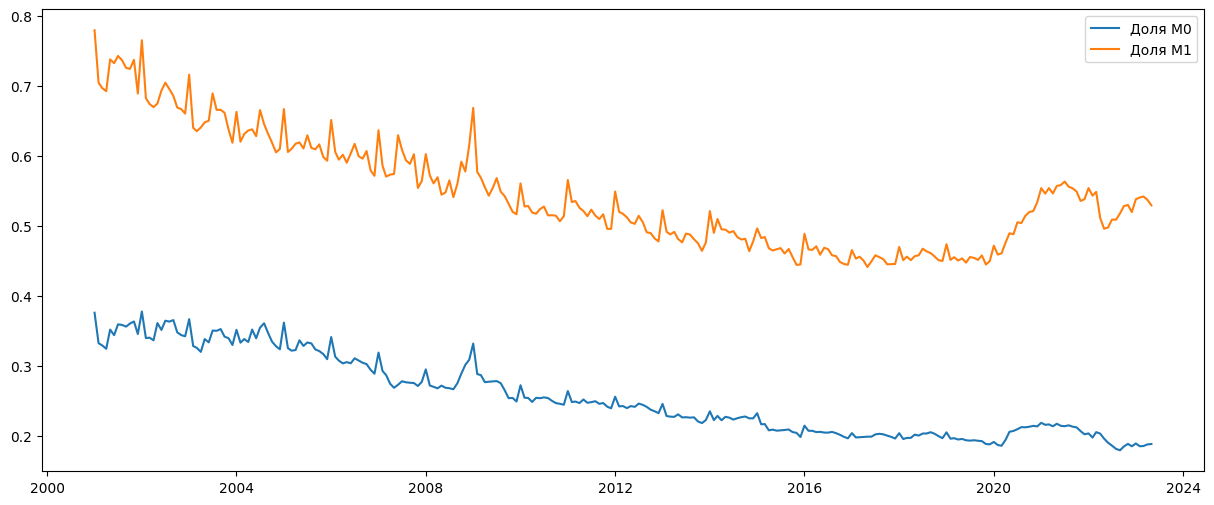

In [11]:
fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(m.date, m['Доля М0'], label='Доля М0')
ax.plot(m.date, m['Доля М1'], label='Доля М1')

ax.legend()

# Импорт признаков ИПП

возьмем для ИПЦ:
- news
- curs
- interest_rate

In [12]:
df = pd.read_csv('../data/preprocessed_ipp_factors.csv')
df.date = pd.to_datetime(df.date).dt.date.apply(lambda x: datetime.date(year=x.year, month=x.month, day=1))
features = df[['date', 'news', 'curs', 'interest_rate']]

In [13]:
features

,date,news,curs,interest_rate
0,2015-01-01,-1.551464,65.153087,15.380952
1,2015-02-01,-1.756337,64.518174,13.789474
2,2015-03-01,-1.972270,60.363090,13.409091
3,2015-04-01,-1.537923,53.218695,13.575000
4,2015-05-01,-0.836183,50.467958,12.525000
...,...,...,...,...
103,2023-08-01,0.608112,95.285348,11.309524
104,2023-09-01,0.243075,96.622259,11.625000
105,2023-10-01,0.425872,97.122281,11.568182
106,2023-11-01,0.848450,90.412790,13.113636


# Импорт ИПЦ

In [14]:
ipc = pd.read_csv('../data/Базовый индекс потребительских цен.csv', sep=';')
ipc.date = pd.to_datetime(ipc.date, format='%d.%m.%Y').dt.date.apply(lambda x: datetime.date(year=x.year, month=x.month, day=1))

In [15]:
ipc

,dataset,date,"Базовый индекс потребительских цен, индекс, Россия"
0,69798,2003-01-01,1.0120
1,69798,2003-02-01,1.0088
2,69798,2003-03-01,1.0068
3,69798,2003-04-01,1.0063
4,69798,2003-05-01,1.0057
...,...,...,...
241,69798,2023-02-01,1.0013
242,69798,2023-03-01,1.0037
243,69798,2023-04-01,1.0031
244,69798,2023-05-01,1.0052


# Обьединение данных

In [16]:
df = ipc.merge(features, on='date').merge(m, on='date')
df = df.drop(columns=['dataset_x', 'dataset_y'])

In [17]:
df

,date,"Базовый индекс потребительских цен, индекс, Россия",news,curs,interest_rate,"Денежная масса, млрд нац ден ед, Россия",Денежный агрегат М0,Денежный агрегат М1,Доля М0,Доля М1
0,2015-01-01,1.0352,-1.551464,65.153087,15.380952,30906.0,7171.5,15341.4,0.232042,0.496389
1,2015-02-01,1.0235,-1.756337,64.518174,13.789474,30989.0,6700.3,14955.2,0.216215,0.482597
2,2015-03-01,1.0147,-1.972270,60.363090,13.409091,30825.0,6671.9,14921.0,0.216444,0.484055
3,2015-04-01,1.0080,-1.537923,53.218695,13.575000,31517.0,6540.9,14749.8,0.207536,0.467995
4,2015-05-01,1.0055,-0.836183,50.467958,12.525000,31742.0,6619.6,14753.7,0.208544,0.464801
...,...,...,...,...,...,...,...,...,...,...
96,2023-01-01,1.0030,-0.480049,68.875975,8.525000,81806.0,15435.7,44018.5,0.188687,0.538084
97,2023-02-01,1.0013,-0.273628,72.782750,8.277778,83151.0,15361.2,44964.6,0.184739,0.540758
98,2023-03-01,1.0037,0.084083,76.103586,8.083333,84159.0,15576.6,45621.0,0.185085,0.542081
99,2023-04-01,1.0031,0.001142,80.995543,8.425000,84418.0,15819.6,45350.5,0.187396,0.537214


In [18]:
df.columns = ['date', 'ipc', 'news', 'curs', 'interest_rate', 'money_supply', 'm0', 'm1', 'share_m0', 'share_m1']

In [19]:
df.to_csv('../data/ipc_preprocessed_factors.csv')

# Предобработка

In [20]:
features = df.columns[1:]

In [21]:
df['ipc_lag_1'] = df['ipc'].shift(1) ** 2
df['ipc_lag_2'] = df['ipc'].shift(2) ** 2
df['ipc_lag_3'] = df['ipc'].shift(3) ** 2

for feature in features:
    for i in range(1, 3 + 1):
        df[f'{feature}_lag_{i}'] = df[feature].shift(i)

df = df.fillna(method='pad')


In [22]:
exog_var = [
    'curs',
    'interest_rate',
    'ipc_lag_1',
    'share_m0',
    'share_m1',
    'news',
]

<Axes: >

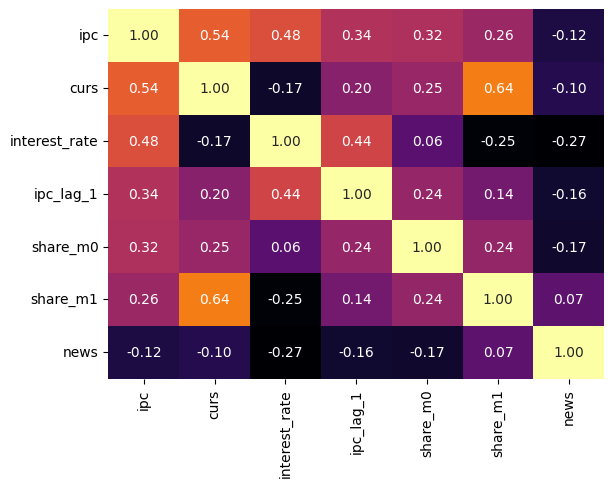

In [23]:
sns.heatmap(
    df[['ipc'] + exog_var].corr(),
    fmt=".2f",
    annot=True,
    cmap='inferno',
    cbar=False
)

In [24]:
exog_var = [
    'curs_lag_1',
    'interest_rate_lag_1',
    'ipc_lag_2',
    'share_m0_lag_1',
    'share_m1_lag_1',
    'news_lag_1',
]

<Axes: >

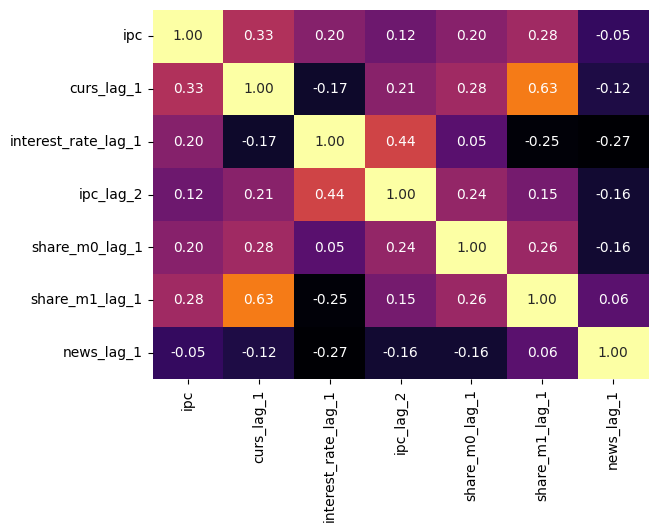

In [25]:
sns.heatmap(
    df[['ipc'] + exog_var].corr(),
    fmt=".2f",
    annot=True,
    cmap='inferno',
    cbar=False
)

решил в общем без лагов лучше, видимо индекс очень краткосрочный

In [26]:
df.drop(columns=['date']).corr().sort_values(by='ipc', ascending=False)[['ipc']].head(15)

,ipc
ipc,1.000000
curs,0.537138
interest_rate,0.481955
ipc_lag_1,0.335265
curs_lag_1,0.330100
share_m0,0.323756
share_m1_lag_2,0.319369
share_m1_lag_3,0.286375
share_m1_lag_1,0.280741
curs_lag_2,0.260603


Text(0, 0.5, 'ИПЦ')

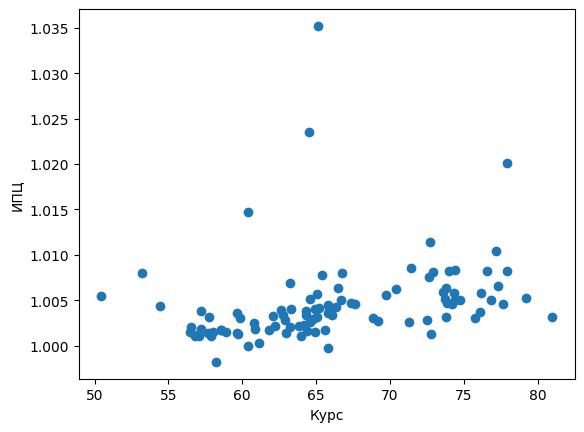

In [27]:
plt.scatter(df[df.curs < 100].curs, df[df.curs < 100].ipc)
plt.xlabel('Курс')
plt.ylabel('ИПЦ')

Text(0, 0.5, 'ИПЦ')

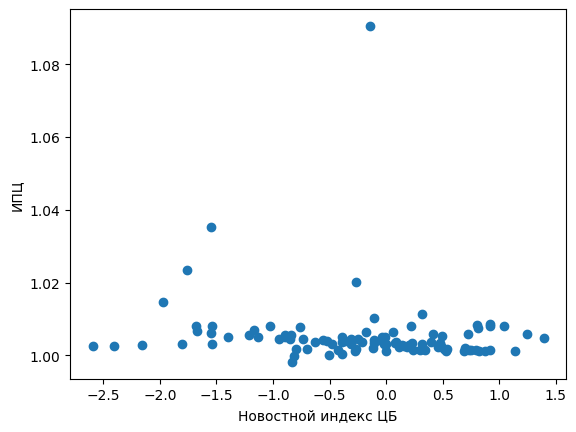

In [28]:
plt.scatter(df.news, df.ipc)
plt.xlabel('Новостной индекс ЦБ')
plt.ylabel('ИПЦ')

Text(0, 0.5, 'ИПЦ')

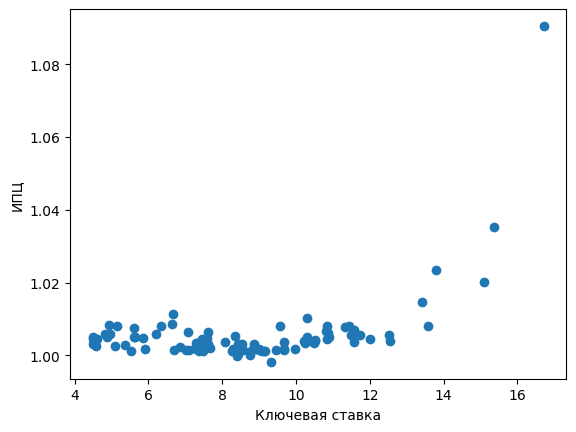

In [29]:
plt.scatter(df.interest_rate, df.ipc)
plt.xlabel('Ключевая ставка')
plt.ylabel('ИПЦ')

Text(0, 0.5, 'ИПЦ')

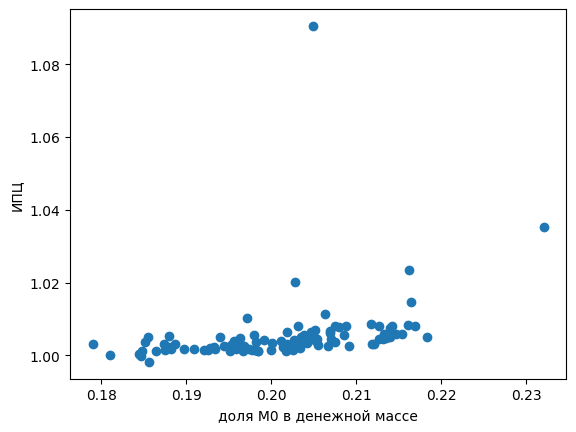

In [30]:
plt.scatter(df.share_m0, df.ipc)
plt.xlabel('доля М0 в денежной массе')
plt.ylabel('ИПЦ')

# Модель catboost

In [57]:
def train_test_split(exog_var, goal):
    X_train = df[df.date < datetime.date(year=2022, month=6, day=1)][exog_var].fillna(method='bfill')
    Y_train = df[df.date < datetime.date(year=2022, month=6, day=1)][goal].fillna(method='bfill')
    
    X_test = df[df.date >= datetime.date(year=2022, month=6, day=1)][exog_var]
    Y_test = df[df.date >= datetime.date(year=2022, month=6, day=1)][goal]
    
    return X_train, X_test, Y_train, Y_test

In [58]:
# Для прогноза на 1 месяц
exog_var_1 = [
    'curs_lag_1',
    'interest_rate_lag_1',
    'ipc_lag_2',
    'share_m0_lag_1',
    'share_m1_lag_1',
    'news_lag_1',
]

# Для прогноза на 2 месяца
exog_var_2 = [
    'curs_lag_2',
    'interest_rate_lag_2',
    'share_m0_lag_2',
    'share_m1_lag_2',
    'news_lag_2',
]

# Для прогноза на 3 месяц
exog_var_3 = [
    'curs_lag_3',
    'interest_rate_lag_3',
    'share_m0_lag_3',
    'share_m1_lag_3',
    'news_lag_3',
]

# Модель на 1 месяц

In [59]:
X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(exog_var_1, 'ipc')

grid = {
    'iterations':    [6, 8, 16], 
    'depth':         [3, 6, 8],
    'l2_leaf_reg':   [0.005, 0.01,  0.1,  0.5, 1],
    'learning_rate': [0.001, 0.01, 0.1, 0.5, 1]
}


res = CatBoostRegressor(verbose=False, loss_function='RMSE')\
    .grid_search(
        grid, X_train_1, Y_train_1, 
        calc_cv_statistics=True,
        search_by_train_test_split=True,
        refit=True, verbose=0
)


model_1 = CatBoostRegressor(**res['params'], verbose = False)
model_1.fit(X_train_1, Y_train_1)


bestTest = 0.9979440203
bestIteration = 5


bestTest = 0.9461133259
bestIteration = 5


bestTest = 0.544324688
bestIteration = 5


bestTest = 0.1519351318
bestIteration = 5


bestTest = 0.2361922943
bestIteration = 0


bestTest = 0.9979459482
bestIteration = 5


bestTest = 0.9461317163
bestIteration = 5


bestTest = 0.5444351287
bestIteration = 5


bestTest = 0.1519046907
bestIteration = 5


bestTest = 0.236087305
bestIteration = 4


bestTest = 0.9979800109
bestIteration = 5


bestTest = 0.9464567801
bestIteration = 5


bestTest = 0.5463972213
bestIteration = 5


bestTest = 0.1513878428
bestIteration = 5


bestTest = 0.2343960513
bestIteration = 1


bestTest = 0.9981190321
bestIteration = 5


bestTest = 0.947785456
bestIteration = 5


bestTest = 0.5545770535
bestIteration = 5


bestTest = 0.1497779676
bestIteration = 5


bestTest = 0.2260451815
bestIteration = 5


bestTest = 0.9982715874
bestIteration = 5


bestTest = 0.9492461997
bestIteration = 5


bestTest = 0.5637896875
bestIterat

# Модель на 2 месяца

In [60]:
X_train_2, X_test_2, Y_train_2, Y_test_2 = train_test_split(exog_var_2, 'ipc')

grid = {
    'iterations':    [6, 8, 16], 
    'depth':         [3, 6, 8],
    'l2_leaf_reg':   [0.005, 0.01,  0.1,  0.5, 1],
    'learning_rate': [0.001, 0.01, 0.1, 0.5, 1]
}


res = CatBoostRegressor(verbose=False, loss_function='RMSE')\
    .grid_search(
        grid, X_train_2, Y_train_2, 
        calc_cv_statistics=True,
        search_by_train_test_split=True,
        refit=True, verbose=0
)


model_2 = CatBoostRegressor(**res['params'], verbose = False)
model_2.fit(X_train_2, Y_train_2)


bestTest = 0.9978319877
bestIteration = 5


bestTest = 0.94499302
bestIteration = 5


bestTest = 0.532578421
bestIteration = 5


bestTest = 0.01406741757
bestIteration = 5


bestTest = 0.00227532059
bestIteration = 1


bestTest = 0.9978340456
bestIteration = 5


bestTest = 0.9450127365
bestIteration = 5


bestTest = 0.5327044805
bestIteration = 5


bestTest = 0.01412739655
bestIteration = 5


bestTest = 0.002279137677
bestIteration = 1


bestTest = 0.997870665
bestIteration = 5


bestTest = 0.9453636459
bestIteration = 5


bestTest = 0.5349541424
bestIteration = 5


bestTest = 0.01534918209
bestIteration = 5


bestTest = 0.0038472419
bestIteration = 1


bestTest = 0.9980244604
bestIteration = 5


bestTest = 0.9468387941
bestIteration = 5


bestTest = 0.5445214391
bestIteration = 5


bestTest = 0.02264174507
bestIteration = 5


bestTest = 0.006339550137
bestIteration = 4


bestTest = 0.9981990692
bestIteration = 5


bestTest = 0.9485158616
bestIteration = 5


bestTest = 0.555578319
bes

# Модель на 3 месяца

In [61]:
X_train_3, X_test_3, Y_train_3, Y_test_3 = train_test_split(exog_var_3, 'ipc')

grid = {
    'iterations':    [6, 8, 16], 
    'depth':         [3, 6, 8],
    'l2_leaf_reg':   [0.005, 0.01,  0.1,  0.5, 1],
    'learning_rate': [0.001, 0.01, 0.1, 0.5, 1]
}


res = CatBoostRegressor(verbose=False, loss_function='RMSE')\
    .grid_search(
        grid, X_train_3, Y_train_3, 
        calc_cv_statistics=True,
        search_by_train_test_split=True,
        refit=True, verbose=0
)


model_3 = CatBoostRegressor(**res['params'], verbose = False)
model_3.fit(X_train_3, Y_train_3)


bestTest = 0.9978856553
bestIteration = 5


bestTest = 0.9455220391
bestIteration = 5


bestTest = 0.5372129386
bestIteration = 5


bestTest = 0.03515740072
bestIteration = 5


bestTest = 0.003771301097
bestIteration = 0


bestTest = 0.9978881385
bestIteration = 5


bestTest = 0.9455457161
bestIteration = 5


bestTest = 0.5373556626
bestIteration = 5


bestTest = 0.03517244868
bestIteration = 5


bestTest = 0.00370346108
bestIteration = 0


bestTest = 0.9979314924
bestIteration = 5


bestTest = 0.9459593882
bestIteration = 5


bestTest = 0.5398695811
bestIteration = 5


bestTest = 0.03549540315
bestIteration = 5


bestTest = 0.005059116695
bestIteration = 5


bestTest = 0.9981012066
bestIteration = 5


bestTest = 0.9475828293
bestIteration = 5


bestTest = 0.5500293108
bestIteration = 5


bestTest = 0.03806859579
bestIteration = 5


bestTest = 0.008254196619
bestIteration = 3


bestTest = 0.9982800873
bestIteration = 5


bestTest = 0.9492984829
bestIteration = 5


bestTest = 0.5611124

# Качество моделей

In [36]:
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_absolute_error

т.к. ИПЦ и так в процентах, то посчитаем MAE

## Модель 1

In [62]:
train_predict = model_1.predict(X_train_1)
test_predict = model_1.predict(X_test_1)

print(f'r2_score:   {np.round(r2_score(Y_train_1, train_predict), 3)}')
print(f'mae train: {np.round(mean_absolute_error(Y_train_1, train_predict), 3) * 100:0.1f}%')
print(f'mae test:  {np.round(mean_absolute_error(Y_test_1, test_predict), 3) * 100:0.1f}%')

r2_score:   0.992
mae train: 0.0%
mae test:  0.3%


## Модель 2

In [63]:
train_predict = model_2.predict(X_train_2)
test_predict = model_2.predict(X_test_2)

print(f'r2_score:   {np.round(r2_score(Y_train_2, train_predict), 3)}')
print(f'mae train: {np.round(mean_absolute_error(Y_train_2, train_predict), 3) * 100:0.1f}%')
print(f'mae test:  {np.round(mean_absolute_error(Y_test_2, test_predict), 3) * 100:0.1f}%')

r2_score:   0.971
mae train: 0.1%
mae test:  0.7%


# Модель 3

In [64]:
train_predict = model_3.predict(X_train_3)
test_predict = model_3.predict(X_test_3)

print(f'r2_score:   {np.round(r2_score(Y_train_3, train_predict), 3)}')
print(f'mae train: {np.round(mean_absolute_error(Y_train_3, train_predict), 3) * 100:0.1f}%')
print(f'mae test:  {np.round(mean_absolute_error(Y_test_3, test_predict), 3) * 100:0.1f}%')

r2_score:   0.938
mae train: 0.1%
mae test:  0.8%


# Визуализация

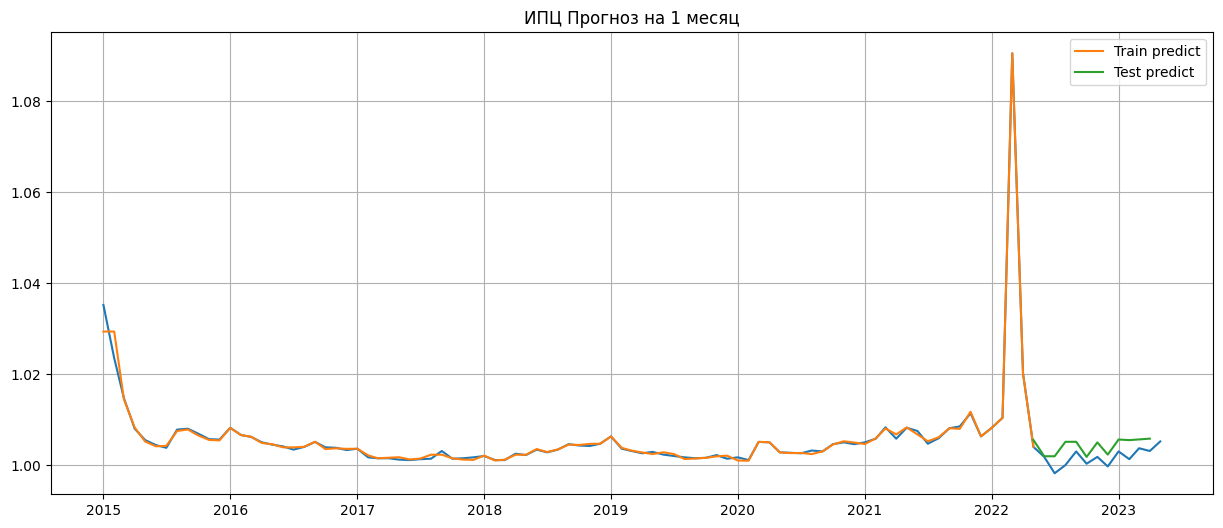

In [65]:
train_predict = model_1.predict(X_train_1)
test_predict = model_1.predict(X_test_1)

fig, ax = plt.subplots(figsize=(15, 6))

ax.set_title('ИПЦ Прогноз на 1 месяц')

ax.plot(df.date, df.ipc)
ax.plot(df.date[:train_predict.shape[0]], train_predict, label='Train predict')
ax.plot(df.date[train_predict.shape[0]-1:-1], test_predict, label='Test predict')

ax.legend()
ax.grid()

# Значимость признаков

In [45]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

X2 = sm.add_constant(X_train_1)
est = sm.OLS(Y_train_1, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     50.79
Date:                Sun, 21 Jul 2024   Prob (F-statistic):           8.80e-25
Time:                        14:10:32   Log-Likelihood:                 398.83
No. Observations:                  84   AIC:                            -783.7
Df Residuals:                      77   BIC:                            -766.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.4481    

Для модели на 3 месяца из значимых признаков только Доля М0 с лагом в 3 месяца

In [46]:
X2 = sm.add_constant(X_train_2)
est = sm.OLS(Y_train_2, X2)
est2 = est.fit()

print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     22.10
Date:                Sun, 21 Jul 2024   Prob (F-statistic):           1.01e-13
Time:                        14:10:34   Log-Likelihood:                 368.65
No. Observations:                  84   AIC:                            -725.3
Df Residuals:                      78   BIC:                            -710.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.9325    

In [47]:
X2 = sm.add_constant(X_train_3)
est = sm.OLS(Y_train_3, X2)
est2 = est.fit()

print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.530
Model:                            OLS   Adj. R-squared:                  0.500
Method:                 Least Squares   F-statistic:                     17.60
Date:                Sun, 21 Jul 2024   Prob (F-statistic):           1.23e-11
Time:                        14:10:35   Log-Likelihood:                 363.31
No. Observations:                  84   AIC:                            -714.6
Df Residuals:                      78   BIC:                            -700.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.9391    